# Cookbook 3 - Computing the Q$_{\ell}$s

Here we provide a recipe, detailing the functionality available in our set of packages, to compute the Q$_{\ell}$s coefficients for a  [ExSHalos](https://arxiv.org/abs/1906.06630) map far away from the observer, considering **redshift space distortions**

## 0) Including the libraries

In [1]:
import theory as theory
from cosmo import cosmo
from code_options import code_parameters #to set the cosmological parameters
import numpy as np
import sys
import pandas as pd
import scipy.interpolate
import matplotlib.pyplot as plt
import deepdish as dd
import mcfit
from scipy.ndimage import gaussian_filter

## 1) Instantiating the parameters

Defining the **cosmology**:

In [2]:
h = 0.6711
zmin = 4.0 #Minimum redshift
zmax = 7.8 #Maximum redshift
zcentral = (zmin + zmax)/2. #Mean redshift in the data
my_cosmology = cosmo(h = h, Omega0_b = 0.049, Omega0_cdm = 0.2685,
              Omega0_k = 0.0, Omega0_DE = 0.6825, A_s = 2.1277e-9,
              n_s = 0.9624, w0 = - 1.0, w1 = 0.0, z_re = 9.99999,
              flat = True, gamma = 0.5454, zcentral = zcentral)

Code options

In [3]:
#Defining the code options
my_code_options = code_parameters(k_min_CAMB = 1e-4, k_max_CAMB = 1e1)

In [4]:
ell_max = 6 #Maximum order to compute the multipoles
all_multipoles = False # True if odd multipoles needed
P_eff = (1.5**2)*2e3 #Value of the power spectrum at a chosen scale
n_bar_r = f"RSD/radial_number_density-L5000.dat" #Name of the file containing the radial number density of objects in the survey
file_rand = f'RSD/random_radecz-L5000.dat' #Path of the random catalog => shape (N, 3)
rmin     = np.asarray([6e-2, 1e-1, 3e-1, 8e-1, 5e1]) #Minimum values of the different bins over which estimate Ql
rmax     = np.asarray([1e-1, 3e-1, 8e-1, 5e1, 1e3]) #Maximum values of the different bins over which estimate Ql
fraction = np.asarray([1, 0.2, 0.1, 0.01, 0.001]) #Fraction of the random catalog to use for each bin computation

Loading the random catalog

In [5]:
random = pd.read_csv(file_rand, skiprows = [0], sep = ' ')
random = random.values

## 2) Estimating the $Q_{\ell}$s

In [6]:
r_dict = {}
Q_dict = {}

N_r    = np.zeros(len(rmin))    
for i in range(len(rmin)):
    if(i == 0):
        Nr = 10 #number of points to be computed in the first iteration
    else:
        Nr = 30 #number of points to be computed in any other iteration
    r_dict[i], Q_dict[i] = theory.q_ell(random, my_cosmology, 
        ell_max = ell_max, rmin = rmin[i], rmax = rmax[i],
        Nr = Nr, all_multipoles = all_multipoles, 
        zmin = zmin, zmax = zmax, fraction = fraction[i], 
        n_bar_r = n_bar_r, P_eff = P_eff, FKP_weights = False, 
                                        Normalize = True)
    
    N_r[i] = len(r_dict[i])

q_ell     = np.zeros((4, int(N_r.sum())))
r_centers = np.zeros(int(N_r.sum()))
for i in range(len(rmin)):
    q_ell[:,int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] = Q_dict[i]
    r_centers[int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] = r_dict[i]
N_ell = q_ell.shape[0]

NameError: name 'my_cosmology' is not defined

## 3) Working with $Q_{\ell}$ values

### a) Normalizing the higher $\ell$ multipoles by $Q_0$

In [ ]:
Q_ell = np.copy(q_ell)

In [ ]:
for i in range(len(rmin)):
    for j in range(1, N_ell):
        Q_ell[j,int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] = ( q_ell[j, int(N_r[:i].sum()):int(N_r[:(i+1)].sum())] / q_ell[0, int(N_r[:i].sum())] )*Q_ell[0, int(N_r[:i].sum())]

### b) For low $r$, the estimates of $Q_\ell$ can get noisy; therefore, when $Q_\ell<0$ for $r < 10$ we set them to zero

In [ ]:
for i in range(4):
    w = np.where((Q_ell[i] < 0) & (r_centers < 10))
    if(len(w[0]) != 0):
        Q_ell[i, :w[0][-1]] = 0

### c) Interpolate $Q_\ell$ to a logspaced vector, and apply a gaussian filter to regularize the values

In [ ]:
# Interpolate Q_ell into a logspaced r so that it works well with FFTLog
r_interp = np.logspace(-2, np.log10(r_centers.max()), len(r_centers))
Q_interp = np.zeros((4, len(r_centers)))

for i in range(4):
    Q_interp[i] = np.interp(r_interp, r_centers, Q_ell[i])
    
w = np.where(Q_interp[0] >= 1)
Q_interp[0,:w[0][-1]] = 1

for i in range(4):
    Q_interp[i,:] = gaussian_filter(Q_interp[i,:], 3)

if(all_multipoles == False):
    ell_index = np.arange(0,N_ell,1)
    ell       = 2*ell_index
if(all_multipoles == True):
    ell_index = np.arange(0,N_ell,1)
    ell       = ell_index

## 4) Saving the results

In [ ]:
np.savetxt(f"Q_ell/r_centers-L5000.dat", r_interp)
np.savetxt(f"Q_ell/Q_ell-L5000.dat", Q_interp)

## 5) Loading the results

In [7]:
r_interp = np.loadtxt(f"Q_ell/r_centers-L5000.dat")
Q_interp = np.loadtxt(f"Q_ell/Q_ell-L5000.dat")
r_interp.shape, Q_interp.shape

((125,), (4, 125))

## 6) Plotting the Q$_{\ell}$s

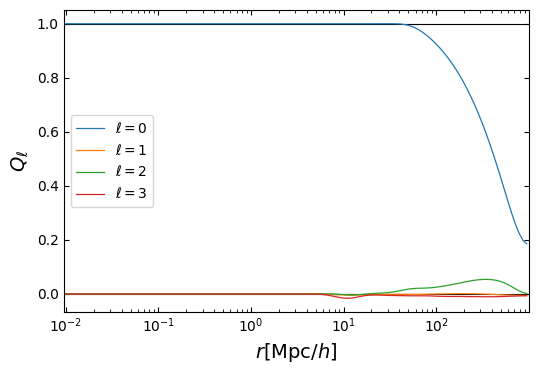

In [8]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')
ax.set_yscale('linear')

ax.set_xlabel('$r[$Mpc$/h]$', fontsize = 14)
ax.set_ylabel('$Q_{\ell}$', fontsize = 14)

for i in range(4):
    ax.plot(r_interp, Q_interp[i], label = f'$\ell = {i}$', linewidth = 0.9)

ax.set_xlim(r_interp[0]*0.95, r_interp[-1]*1.05)

ax.hlines(0, 0.001, 10**3, linewidth = 0.8, color = 'k')
ax.hlines(1, 0.001, 10**3, linewidth = 0.8, color = 'k')

ax.tick_params(axis = 'both', which = 'both', direction = 'in', 
               right = True, top = True)

ax.legend()

plt.savefig(f'Q_ell/L05000-Q_ell.pdf', bbox_inches='tight')

## 7) Working with Q$_{\ell}$s to obtain the window function W$_{\ell}$

Here we are deconvolving the expression
\begin{equation}
 Q ( \mathbf{r} ) = \int \frac{d^3 \mathbf{k}}{(2 \pi)^3} e^{i \mathbf{k \cdot r}} |W (\mathbf{k})|^2
\end{equation}

### a) Deconvolving

In [13]:
k_ell, W0 = mcfit.xi2P(r_interp, l = 0)(Q_interp[0,:])
k_ell, W2 = mcfit.xi2P(r_interp, l = 2)(Q_interp[1,:])
k_ell, W4 = mcfit.xi2P(r_interp, l = 4)(Q_interp[2,:])
k_ell, W6 = mcfit.xi2P(r_interp, l = 6)(Q_interp[3,:])

/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


### b) Normalizing

In [14]:
W0_W1 = W0/np.max(W0)
W2_W1 = W2/np.max(W2)
W4_W1 = W4/np.max(W4)
W6_W1 = W6/np.max(W6)

### c) Saving

In [15]:
Wls = np.zeros(( 5, W0_W1.shape[0] ))
Wls[0] = k_ell
Wls[1] = W0_W1
Wls[2] = W2_W1
Wls[3] = W4_W1
Wls[4] = W6_W1

In [16]:
np.savetxt(f'Q_ell/L05000-Wls.dat', Wls.T)

### d) Plotting

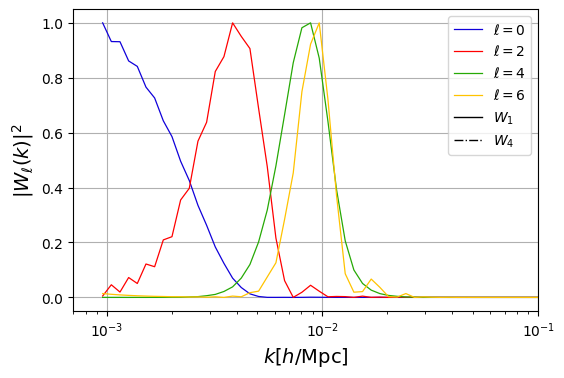

In [17]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')

ax.plot(k_ell, np.abs(W0_W1)**2, color = '#1000DA', linewidth = 0.9, label = r'$\ell = 0$')
ax.plot(k_ell, np.abs(W2_W1)**2, color = '#FF0000', linewidth = 0.9, label = r'$\ell = 2$')
ax.plot(k_ell, np.abs(W4_W1)**2, color = '#26A905', linewidth = 0.9, label = r'$\ell = 4$')
ax.plot(k_ell, np.abs(W6_W1)**2, color = '#FFC300', linewidth = 0.9, label = r'$\ell = 6$')

ax.plot(np.zeros(10), np.zeros(10), color = 'k', linewidth = 1, label = '$W_1$')
ax.plot(np.zeros(10), np.zeros(10), color = 'k', linewidth = 1, linestyle = '-.', label = '$W_4$')

ax.set_xlim(7e-4,1e-1)

ax.set_xlabel('$k[h/$Mpc$]$', fontsize=14)
ax.set_ylabel('$|W_\ell(k)|^2$', fontsize=14)

ax.legend()

ax.grid()

plt.savefig(f'Q_ell/L05000-W_sq.pdf', bbox_inches='tight')

## 8) Convolving Q$_{\ell}$s with this window function

In [18]:
%%time

rsd_pars = theory.rsd_params(b1 = np.asarray([1.0]), 
                             sigma_tot = np.asarray([300])) #Redshiftspace distortion parameters
redshift = np.asarray([1.0])

k_conv, Pk_conv = theory.convolved_multipoles(rsd_pars, 
                                              cosmo, redshift, 
                                              1, r_centers, 
                                              Q_interp) # Theoretical Spectrum convolved with survey window function

Time elapsed for CAMB + I/O: 1.167435646057129
CPU times: user 83.5 ms, sys: 90 µs, total: 83.6 ms
Wall time: 1.25 s


/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:157: UserWarning: input must be log-spaced
  warnings.warn("input must be log-spaced")
/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/usr/local/lib/python3.8/dist-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


Saving it

In [19]:
P_convolved = np.zeros( ( 3, k_conv.shape[0] ) )
P_convolved[0] = k_conv
P_convolved[1] = Pk_conv[0]['P0_z1.0']
P_convolved[2] = Pk_conv[0]['P2_z1.0']

In [20]:
np.savetxt(f'Q_ell/L05000-convolved_spectra.dat', P_convolved.T)

## 9) Compute original multipoles for comparison

Power spectrum using CAMB

In [5]:
Pk_dict = theory.power_spectrum(my_cosmology, my_code_options)
#Pk_dict = theory.power_spectrum(cosmo, 1, redshift, 1e-4, 1e1)

Time elapsed for CAMB + I/O: 1.1280097961425781


Power spectrum multipoles of the redshift-space power spectrum

In [22]:
M_dict = theory.pk_multipoles_gauss(rsd_pars, cosmo, redshift, 1, 
                                    kmin = 1e-4, kmax = 1e1, 
                                    Nk = len(k_conv), k = Pk_dict['k'])

This is the original/theoretical spectra

In [23]:
P_mono = Pk_dict['Pk_'+str(redshift[0])]*M_dict['mono'][0][0]
P_quad = Pk_dict['Pk_'+str(redshift[0])]*M_dict['quad'][0][0]
P_hexa = Pk_dict['Pk_'+str(redshift[0])]*M_dict['hexa'][0][0]

Saving it

In [24]:
P_theoretical = np.zeros( ( 4, P_mono.shape[0] ) )
P_theoretical[0] = Pk_dict['k']
P_theoretical[1] = P_mono
P_theoretical[2] = P_quad
P_theoretical[3] = P_hexa

In [25]:
np.savetxt(f'Q_ell/L05000-theoretical_spectra.dat', P_theoretical.T)

## 10) Comparing the theoretical and computed convolved spectra

### a) $k$ P$_{\ell}$

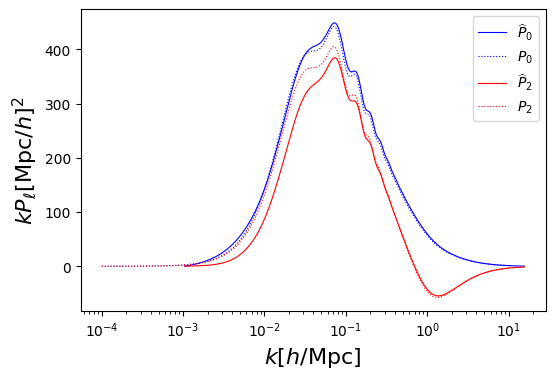

In [26]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')

ax.plot(k_conv, k_conv*Pk_conv[0]['P0_z1.0'], color = 'b', label = '$\widehat{P}_0$', linewidth = 0.8)
ax.plot(Pk_dict['k'], Pk_dict['k']*P_mono, color = 'b', linestyle = ':', linewidth = 0.8, label = '$P_0$')

ax.plot(k_conv, k_conv*Pk_conv[0]['P2_z1.0'], color = 'r', label = '$\widehat{P}_2$', linewidth = 0.8)
ax.plot(Pk_dict['k'], Pk_dict['k']*P_quad, color = 'r', linestyle = ':', linewidth = 0.8, label = '$P_2$')

ax.set_xlabel('$k[h/$Mpc$]$', fontsize = 16)
ax.set_ylabel('$kP_\ell[$Mpc$/h]^2$', fontsize = 16)

ax.legend()

plt.savefig(f'Q_ell/L05000-kP_ell.pdf', bbox_inches = 'tight')

### b) P$_{\ell}$

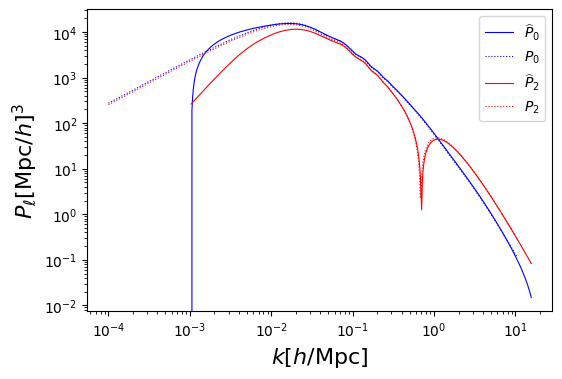

In [27]:
fig, ax = plt.subplots(dpi = 100)

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(k_conv, Pk_conv[0]['P0_z1.0'], color = 'b', label = '$\widehat{P}_0$', linewidth = 0.8)
ax.plot(Pk_dict['k'], P_mono, color = 'b', linestyle = ':', linewidth = 0.8, label = '$P_0$')

ax.plot(k_conv, np.abs(Pk_conv[0]['P2_z1.0']), color = 'r', label = '$\widehat{P}_2$', linewidth = 0.8)
ax.plot(Pk_dict['k'], np.abs(P_quad), color = 'r', linestyle = ':', linewidth = 0.8, label = '$P_2$')

ax.set_xlabel('$k[h/$Mpc$]$', fontsize = 16)
ax.set_ylabel('$P_\ell[$Mpc$/h]^3$', fontsize = 16)

ax.legend()

plt.savefig(f'Q_ell/L05000-P_ell.pdf', bbox_inches='tight')